# Experiment 1-C

Analyses of anthologies: 
 - A Moment Each Day with George Eliot (1903)
 - Wise, Witty, and Tender Sayings in Prose and Verse (1873) 

In [21]:
import json
from collections import Counter
import pandas as pd
from nltk.corpus import names
import nltk
import re 
import os
import difflib 
import logging
import itertools
import numpy as np
from nltk.util import ngrams 
from nltk.stem import LancasterStemmer
from difflib import SequenceMatcher
from string import punctuation
from termcolor import colored
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 6]

In [2]:
# Load the anthologies. 
with open('anthologies/a-moment-mm.txt') as f: 
    moment = f.read()
    
with open('anthologies/witty-middlemarch.txt') as f: 
    witty = f.read()
    
# Load Middlemarch
with open('middlemarch.txt') as f: 
    rawMM = f.read()

In [3]:
class Text: 
    def __init__(self, raw_text, label, removeStopwords=True): 
        if type(raw_text) == list: 
            # JSTOR critical works come in lists, where each item represents a page. 
            self.text = ' \n '.join(raw_text)
        else: 
            self.text = raw_text
        self.label = label
        self.tokens = self.getTokens(removeStopwords)
        self.trigrams = self.ngrams(3)
        
    def getTokens(self, removeStopwords=True): 
        """ Tokenizes the text, breaking it up into words, removing punctuation. """
        tokenizer = nltk.RegexpTokenizer('[a-zA-Z]\w+\'?\w*') # A custom regex tokenizer. 
        #tokenizer = nltk.RegexpTokenizer('\w+|\$[\d\.]+|\S+') # A custom regex tokenizer. 
        spans = list(tokenizer.span_tokenize(self.text))
        # Take note of how many spans there are in the text
        #print(spans)
        self.length = spans[-1][-1] 
        tokens = tokenizer.tokenize(self.text)
        tokens = [ token.lower() for token in tokens ] # make them lowercase
        stemmer = LancasterStemmer()
        tokens = [ stemmer.stem(token) for token in tokens ]
        if not removeStopwords: 
            self.spans = spans
            return tokens
        tokenSpans = list(zip(tokens, spans)) # zip it up
        stopwords = nltk.corpus.stopwords.words('english') # get stopwords
        tokenSpans = [ token for token in tokenSpans if token[0] not in stopwords ] # remove stopwords from zip
        self.spans = [ x[1] for x in tokenSpans ] # unzip; get spans
        return [ x[0] for x in tokenSpans ] # unzip; get tokens
    
    def ngrams(self, n): 
        """ Returns ngrams for the text."""
        return list(ngrams(self.tokens, n))

class Matcher: 
    def __init__(self, textObjA, textObjB, threshold=5, ngramSize=3, removeStopwords=True):
        """
        Takes as input two Text() objects, and matches between them.
        """
        self.threshold = threshold
        self.ngramSize = ngramSize
        
        #self.textA, self.textB = Text(fileA, removeStopwords=removeStopwords), \
        #        Text(fileB, removeStopwords=removeStopwords)
        self.textA = textObjA
        self.textB = textObjB 
        
        self.textAgrams = self.textA.ngrams(ngramSize)
        self.textBgrams = self.textB.ngrams(ngramSize)

        self.locationsA = []
        self.locationsB = []

    def getContext(self, text, start, length, context): 
        match = self.getTokensText(text, start, length)
        before = self.getTokensText(text, start-context, context)
        after = self.getTokensText(text, start+length, context)
        match = colored(match, 'red')
        out = " ".join([before, match, after])
        out = out.replace('\n', ' ') # Replace newlines with spaces. 
        out = re.sub('\s+', ' ', out)
        return out

    def getTokensText(self, text, start, length):  
        """ Looks up the passage in the original text, using its spans. """
        matchTokens = text.tokens[start:start+length]
        spans = text.spans[start:start+length]
        if len(spans) == 0: 
            # Don't try to get text or context beyond the end of a text. 
            passage = ""
        else: 
            passage = text.text[spans[0][0]:spans[-1][-1]]
        return passage 

    def getLocations(self, text, start, length, asPercentages=False): 
        """ Gets the numeric locations of the match. """
        spans = text.spans[start:start+length]
        if asPercentages: 
            locations = (spans[0][0]/text.length, spans[-1][-1]/text.length)
        else: 
            locations = (spans[0][0], spans[-1][-1])
        return locations

    def getMatch(self, match, textA, textB, context): 
        length = match.size + self.ngramSize - 1 # offset according to nGram size 
        wordsA = self.getContext(textA, match.a, length, context)
        wordsB = self.getContext(textB, match.b, length, context)
        spansA = self.getLocations(textA, match.a, length)
        spansB = self.getLocations(textB, match.b, length)
        self.locationsA.append(spansA)
        self.locationsB.append(spansB)
        line1 = ('%s: %s %s' % (colored(textA.label, 'green'), spansA, wordsA) )
        line2 = ('%s: %s %s' % (colored(textB.label, 'green'), spansB, wordsB) )
        return line1 + '\n' + line2

    def match(self): 
        """
        This does the main work of finding matching n-gram sequences between
        the texts.
        """
        sequence = SequenceMatcher(None,self.textAgrams,self.textBgrams)
        matchingBlocks = sequence.get_matching_blocks()

        # Only return the matching sequences that are higher than the 
        # threshold given by the user. 
        highMatchingBlocks = [match for match in matchingBlocks if match.size > self.threshold]
    
        numBlocks = len(highMatchingBlocks)
        self.numMatches = numBlocks
        
        if numBlocks > 0: 
            print('%s total matches found.' % numBlocks, flush=True)

        for num, match in enumerate(highMatchingBlocks): 
            print('match: ', match)
            out = self.getMatch(match, self.textA, self.textB, 5)
            print('\n')
            print('match %s:' % (num+1), flush=True)
            print(out, flush=True)

        return self.numMatches, self.locationsA, self.locationsB

In [4]:
mm = Text(rawMM, 'Middlemarch')

In [5]:
w = Text(witty, 'Witty')
m = Text(moment, 'A Moment')

In [7]:
wittyMatches = Matcher(mm, w).match()

85 total matches found.
match:  Match(a=4, b=7, size=43)


match 1:
Middlemarch: (56, 511)  cares much to know the history of man, and how the mysterious mixture behaves under the varying experiments of Time, has not dwelt, at least briefly, on the life of Saint Theresa, has not smiled with some gentleness at the thought of the little girl walking forth one morning hand-in-hand with her still smaller brother, to go and seek martyrdom in the country of the Moors? Out they toddled from rugged Avila, wide-eyed and helpless-looking as two fawns human hearts, already beating to a national
Witty: (90, 546) MIDDLEMARCH. George Eliot {in propria persona cares much to know the history of man, and how that mysterious mixture behaves under the varying experiments of Time, has not dwelt, at least briefly, on the life of Saint Theresa, has not smiled with some gentleness at the thought of the little girl walking forth one morning hand-in-hand with her still smaller brother, to go and seek martyrdom

In [8]:
momentMatches = Matcher(mm, m).match()

4 total matches found.
match:  Match(a=1581, b=164, size=6)


match 1:
Middlemarch: (16976, 17044) said Dorothea, stroking her sister's cheek Souls have complexions too: what will suit one will not suit another might like to keep it for mamma's sake
A Moment: (1715, 1783) may have a charm until she becomes didactic Souls have complexions too: what will suit one will not suit another set a watch over our affections and our constancy
match:  Match(a=13485, b=216, size=13)


match 2:
Middlemarch: (145417, 145553) may have an appetite for submission afterwards certainly, the mistakes that we male and female mortals make when we have our own way might fairly raise some wonder that we are so fond gray but dry November morning Dorothea
A Moment: (2243, 2378) bear, than the fear, “I shall love her no more Certainly the mistakes that we male and female mortals make when we have our own way might fairly raise some wonder that we are so fond have in general but little feeling seems
match:  Match(

In [17]:
def plotMatches(matches, textALength): 
    # Just get starts of locations in A
    starts = [match[0] for match in matches[1]]
    hist, bins = np.histogram(starts, bins=50, range=(0, textALength))
    pd.Series(hist).plot(kind='bar')

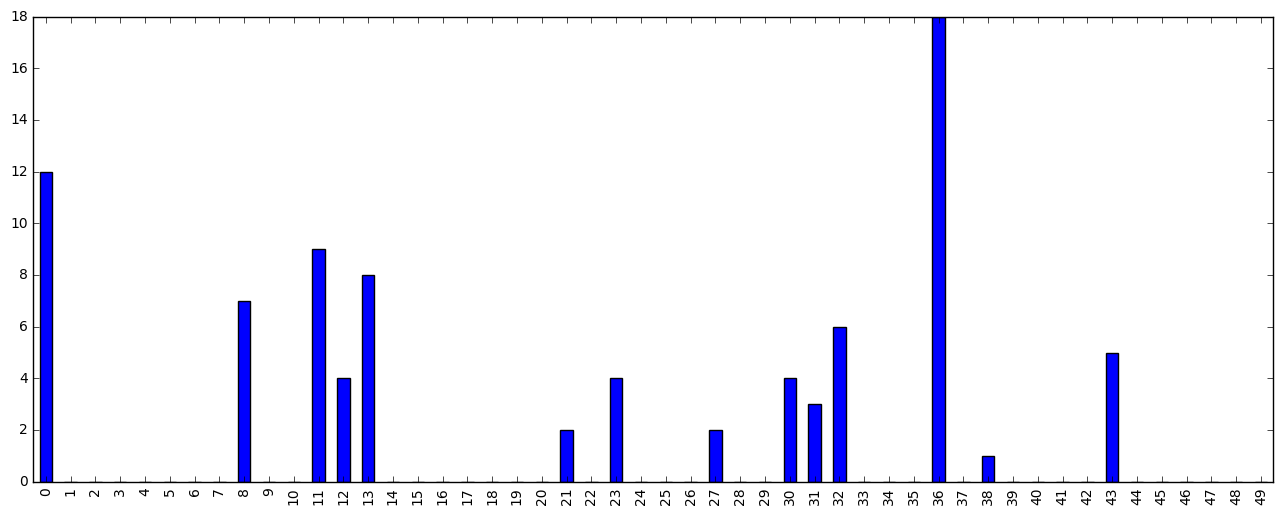

In [22]:
plotMatches(wittyMatches, mm.length)

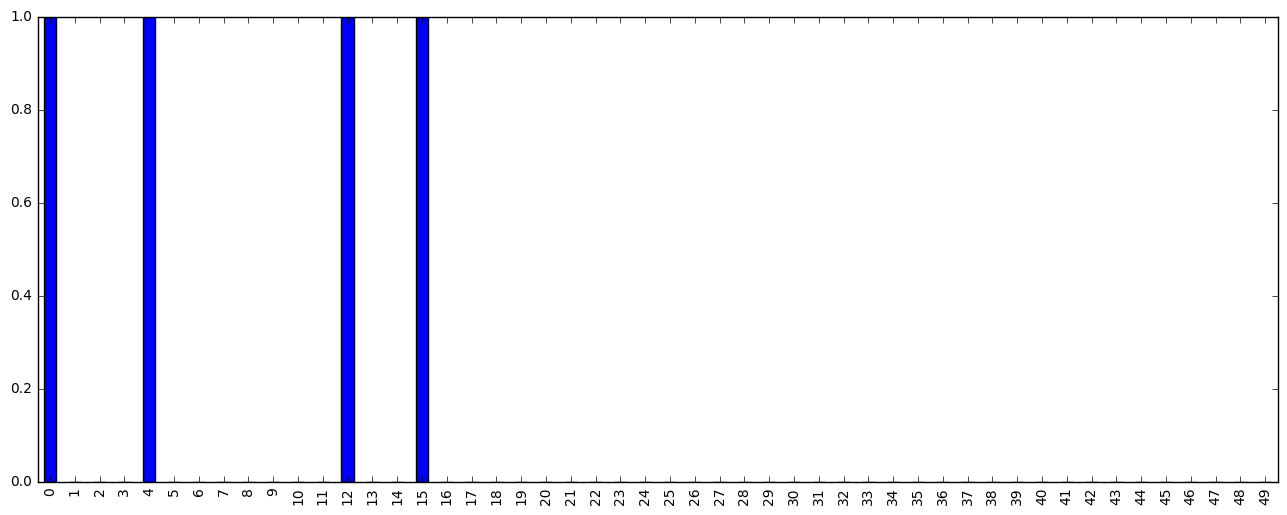

In [23]:
plotMatches(momentMatches, mm.length)